In [16]:
# Common
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Hugging Face
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Load data
test_df = pd.read_csv("../data/splits/test.csv")
test_df.dropna(inplace=True)
test_texts = test_df["clean_text"].tolist()
test_labels = test_df["label"].tolist()

In [ ]:
# Load data for distilbert
test_df_bert = pd.read_csv("../data/splits/raw/test_raw.csv")
test_df_bert.dropna(inplace=True)
test_texts_bert = test_df_bert["text"].tolist()
test_labels_bert = test_df_bert["label"].tolist()

## Logistic Regression

In [ ]:
model_path = "../models/logistic_model.pkl"

logistic_pipeline = joblib.load(model_path)

logistic_preds = logistic_pipeline.predict(test_texts)

## Fine tuned distilbert

In [ ]:
model_checkpoint = "cornualghost/tm4spam-distilbert"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
bert_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Predictions

In [9]:
logistic_preds = logistic_pipeline.predict(test_texts)

In [17]:
# Parameters
batch_size = 16

# Tokenize everything
test_encodings = tokenizer(test_texts_bert, truncation=True, padding=True, return_tensors="pt")

# DataLoader
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Predictions
bert_model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = [b.to(device) for b in batch]
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        all_preds.extend(preds)

bert_preds = np.array(all_preds)

## Report Comparison

In [11]:
print("Logistic Regression Classification Report:")
print(classification_report(test_labels, logistic_preds, digits=3))

print("DistilBERT Classification Report:")
print(classification_report(test_labels_bert, bert_preds, digits=3))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0      0.896     0.948     0.921      5036
           1      0.917     0.841     0.878      3485

    accuracy                          0.904      8521
   macro avg      0.907     0.894     0.899      8521
weighted avg      0.905     0.904     0.903      8521

DistilBERT Classification Report:
              precision    recall  f1-score   support

           0      0.990     0.990     0.990      5038
           1      0.986     0.986     0.986      3486

    accuracy                          0.989      8524
   macro avg      0.988     0.988     0.988      8524
weighted avg      0.989     0.989     0.989      8524



## Confusion Matrix

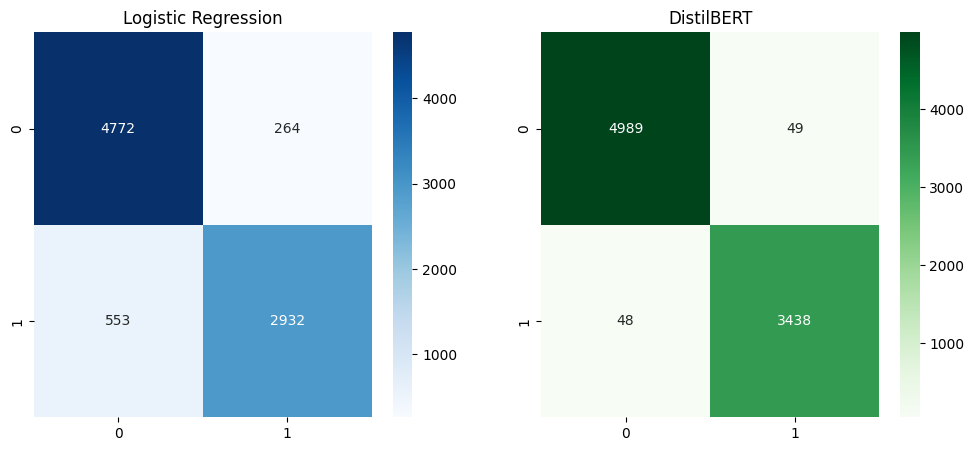

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression
sns.heatmap(confusion_matrix(test_labels, logistic_preds), annot=True, fmt='d', ax=axes[0], cmap="Blues")
axes[0].set_title("Logistic Regression")

# DistilBERT
sns.heatmap(confusion_matrix(test_labels_bert, bert_preds), annot=True, fmt='d', ax=axes[1], cmap="Greens")
axes[1].set_title("DistilBERT")

plt.show()


## Comparative Table

In [15]:
# Metrics Logistic Regression
logistic_precision = precision_score(test_labels, logistic_preds)
logistic_recall = recall_score(test_labels, logistic_preds)
logistic_f1 = f1_score(test_labels, logistic_preds)
logistic_accuracy = accuracy_score(test_labels, logistic_preds)

# Metrics DistilBERT
bert_precision = precision_score(test_labels_bert, bert_preds)
bert_recall = recall_score(test_labels_bert, bert_preds)
bert_f1 = f1_score(test_labels_bert, bert_preds)
bert_accuracy = accuracy_score(test_labels_bert, bert_preds)

# table
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "DistilBERT"],
    "Precision": [logistic_precision, bert_precision],
    "Recall": [logistic_recall, bert_recall],
    "F1-Score": [logistic_f1, bert_f1],
    "Accuracy": [logistic_accuracy, bert_accuracy]
})

print("Summary:")
display(results_df.round(3))


Summary:


,Model,Precision,Recall,F1-Score,Accuracy
0,Logistic Regression,0.917,0.841,0.878,0.904
1,DistilBERT,0.986,0.986,0.986,0.989
